Loading data...

Analyzing Japan data...
Running GES algorithm for Japan...

Japan - GES Analysis Results:
Network Metrics: {'nodes': 15, 'edges': 44, 'average_degree': 2.933333333333333, 'is_dag': True}
Key Nodes: {'highest_influence': 'ZJOYREAD_1', 'most_influenced': 'ZPERCOOP_1', 'highest_betweenness': 'ZDISCLIMA_1'}


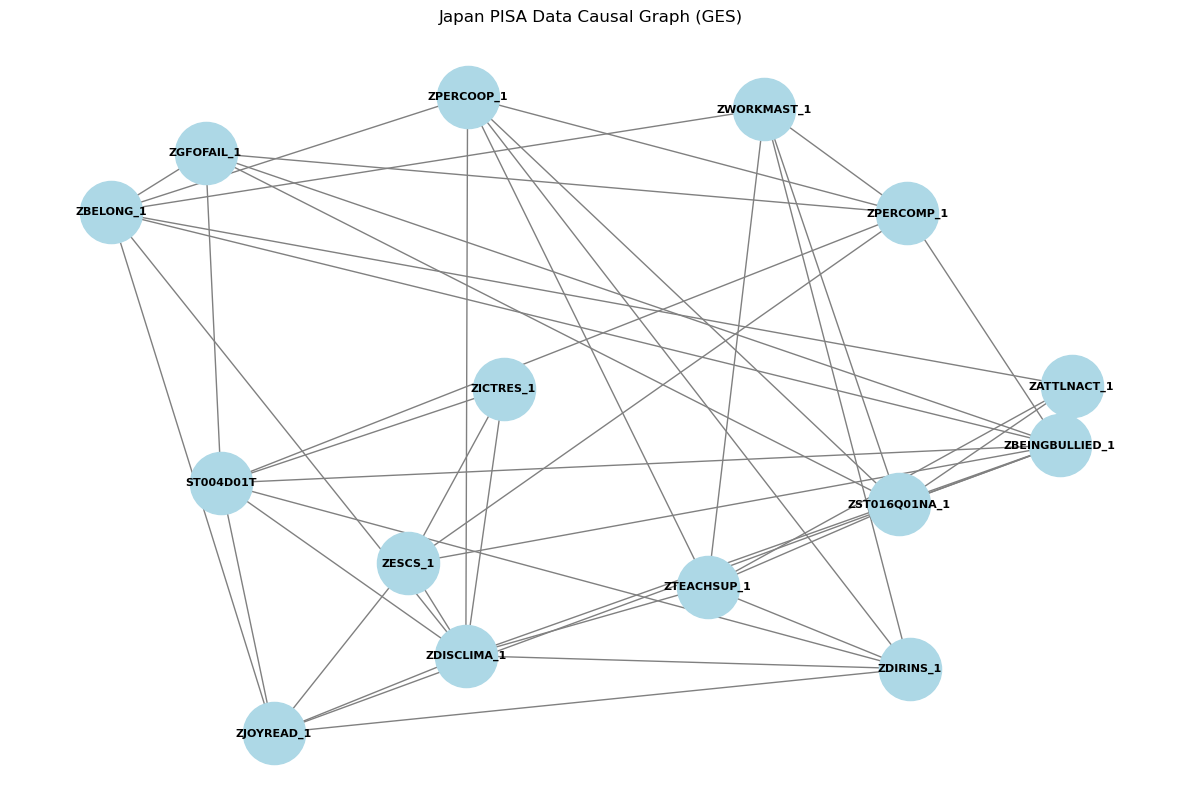

Running PC algorithm for Japan...


Depth=8, working on node 15: 100%|██████████| 16/16 [00:00<00:00, 694.21it/s]



Japan - PC Analysis Results:
Network Metrics: {'nodes': 16, 'edges': 49, 'average_degree': 3.0625, 'is_dag': False}
Key Nodes: {'highest_influence': 'ST004D01T', 'most_influenced': 'ZPERCOMP_1', 'highest_betweenness': 'ZJOYREAD_1'}


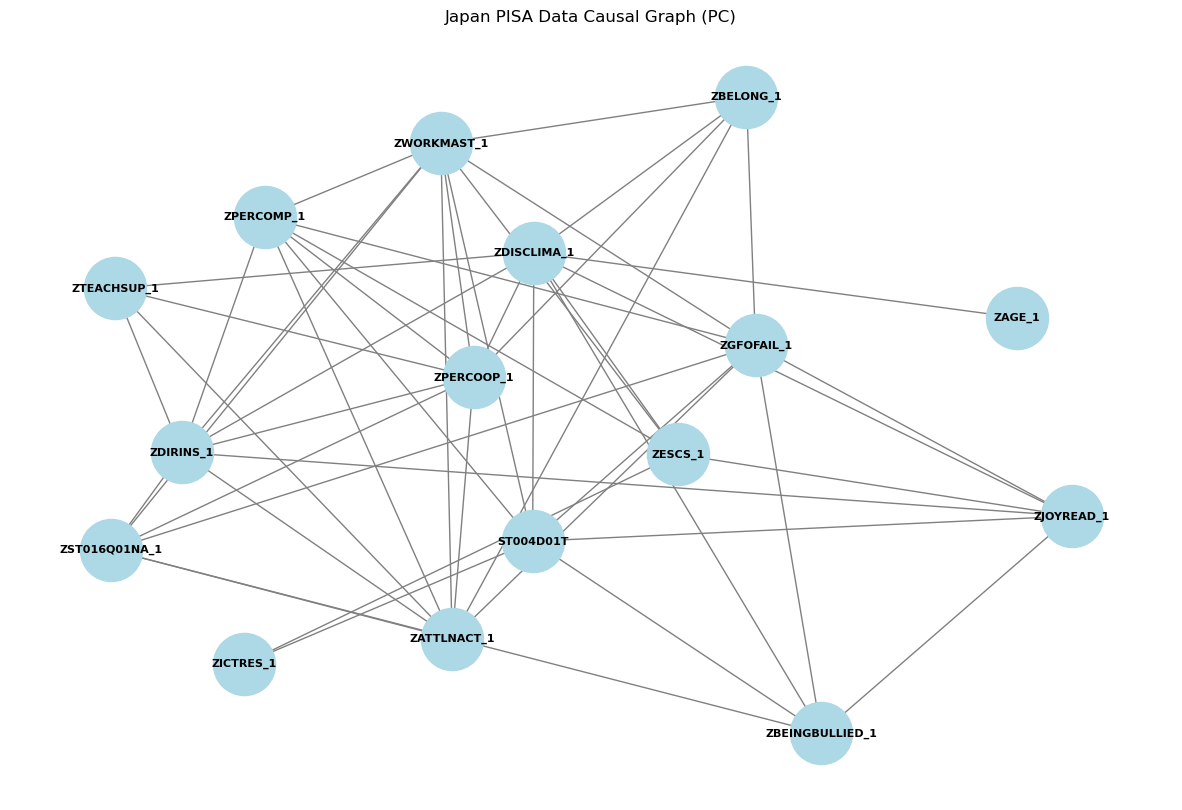


Analyzing UK data...
Running GES algorithm for UK...

UK - GES Analysis Results:
Network Metrics: {'nodes': 15, 'edges': 58, 'average_degree': 3.8666666666666667, 'is_dag': True}
Key Nodes: {'highest_influence': 'ZDISCLIMA_1', 'most_influenced': 'ZWORKMAST_1', 'highest_betweenness': 'ZESCS_1'}


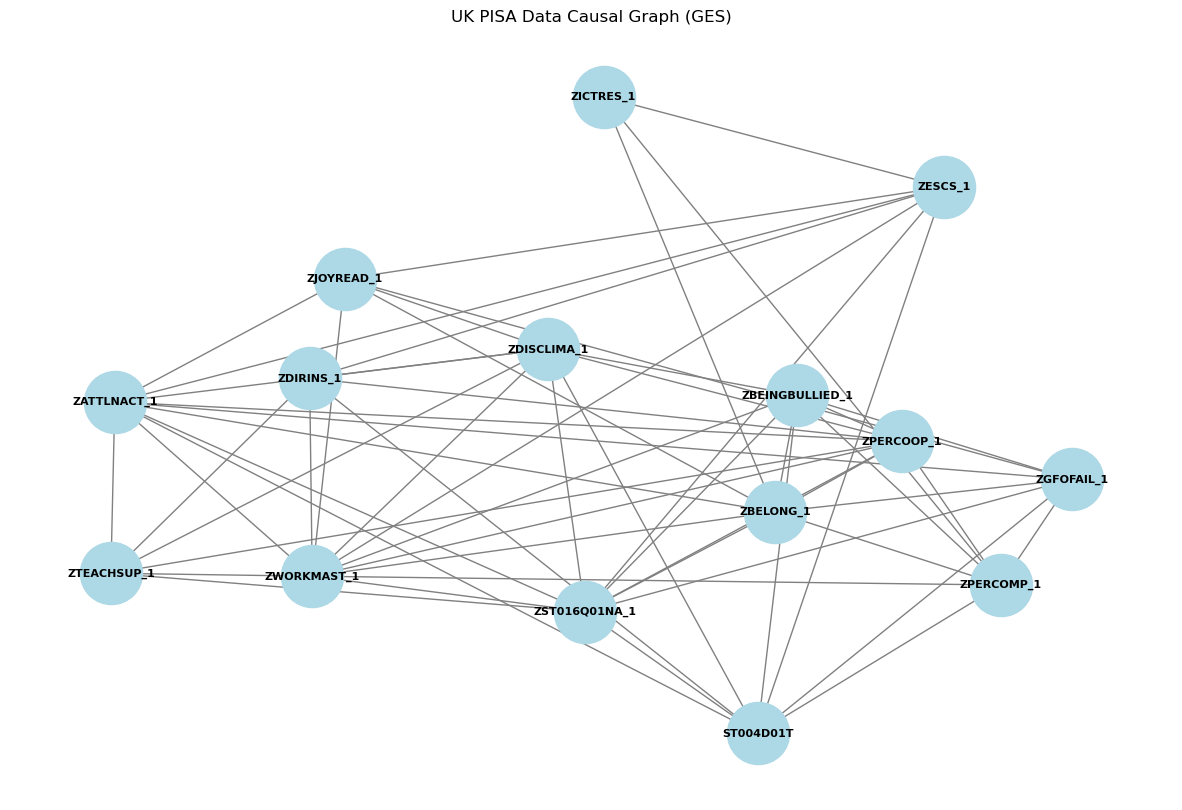

Running PC algorithm for UK...


Depth=10, working on node 15: 100%|██████████| 16/16 [00:00<00:00, 757.44it/s] 



UK - PC Analysis Results:
Network Metrics: {'nodes': 16, 'edges': 59, 'average_degree': 3.6875, 'is_dag': False}
Key Nodes: {'highest_influence': 'ZBELONG_1', 'most_influenced': 'ZST016Q01NA_1', 'highest_betweenness': 'ZATTLNACT_1'}


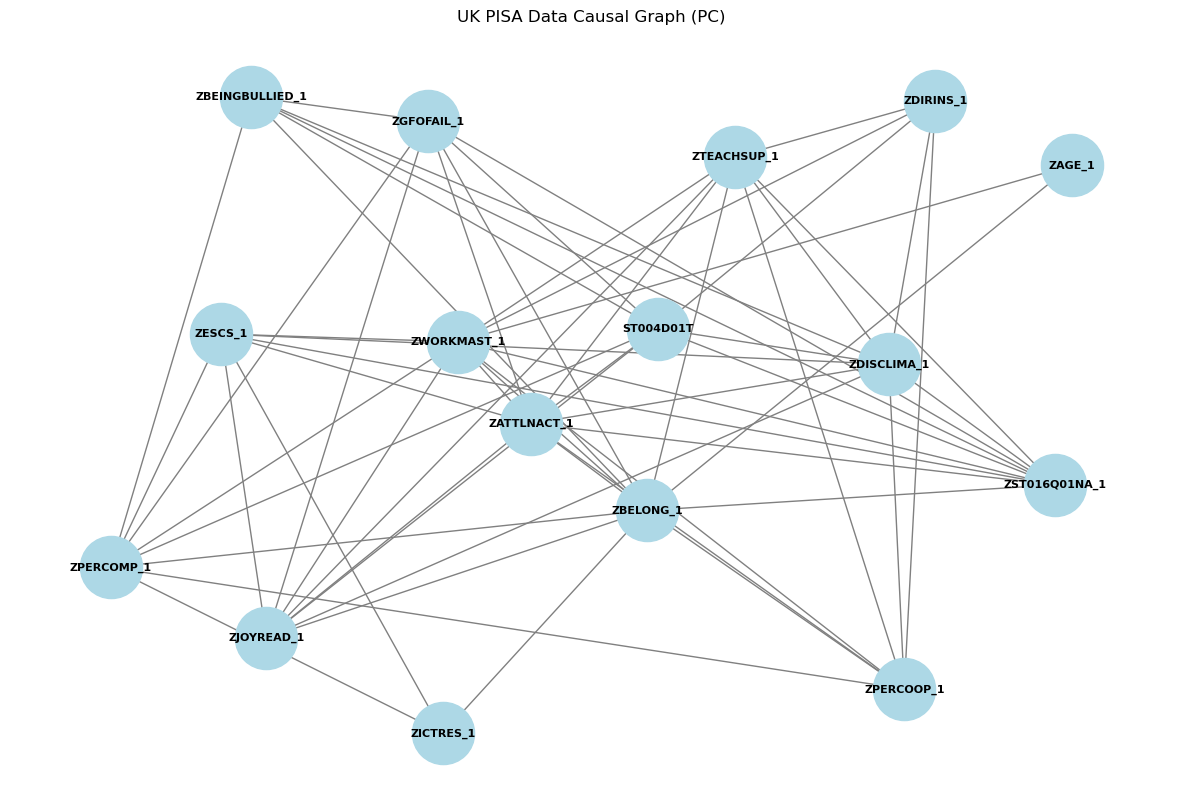

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.search.ConstraintBased.PC import pc
from sklearn.preprocessing import StandardScaler

def process_pisa_data(data):
    """Process PISA dataset for causal analysis"""
    # Define variable groups
    demographic_vars = ['ZAGE_1', 'ST004D01T', 'ZESCS_1']
    school_vars = ['ZICTRES_1', 'ZDISCLIMA_1', 'ZTEACHSUP_1', 'ZDIRINS_1']
    psychological_vars = ['ZJOYREAD_1', 'ZATTLNACT_1', 'ZWORKMAST_1', 'ZGFOFAIL_1']
    social_vars = ['ZBELONG_1', 'ZBEINGBULLIED_1', 'ZPERCOMP_1', 'ZPERCOOP_1']
    
    # Combine all features
    features = demographic_vars + school_vars + psychological_vars + social_vars
    outcome_var = 'ZST016Q01NA_1'
    
    # Select and process data
    df = data[features + [outcome_var]].copy()
    
    # Handle missing values
    df = df.fillna(df.mean())
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_scaled, features + [outcome_var]

def run_causal_discovery(data, variable_names, method='ges'):
    """Run causal discovery using specified method"""
    if method.lower() == 'ges':
        # Run GES algorithm
        record = ges(data.values, score_func='local_score_BIC')
        adj_matrix = record['G'].graph
        
    elif method.lower() == 'pc':
        # Run PC algorithm
        cg = pc(data.values, node_names=variable_names)
        adj_matrix = cg.G.graph
        
    else:
        raise ValueError(f"Unknown method: {method}")
        
    return adj_matrix

def analyze_causal_graph(adj_matrix, variable_names):
    """Analyze the causal graph structure"""
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Add edges based on adjacency matrix
    n = len(variable_names)
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:  # Directed edge i->j
                G.add_edge(variable_names[i], variable_names[j])
    
    # Calculate graph metrics
    metrics = {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'average_degree': float(G.number_of_edges()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        'is_dag': nx.is_directed_acyclic_graph(G)
    }
    
    # Find important nodes
    if G.number_of_nodes() > 0:
        in_centrality = nx.in_degree_centrality(G)
        out_centrality = nx.out_degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        
        key_nodes = {
            'highest_influence': max(out_centrality.items(), key=lambda x: x[1])[0] if out_centrality else None,
            'most_influenced': max(in_centrality.items(), key=lambda x: x[1])[0] if in_centrality else None,
            'highest_betweenness': max(betweenness_centrality.items(), key=lambda x: x[1])[0] if betweenness_centrality else None
        }
    else:
        key_nodes = {
            'highest_influence': None,
            'most_influenced': None,
            'highest_betweenness': None
        }
    
    return G, metrics, key_nodes

def visualize_causal_graph(G, title="Causal Graph"):
    """Visualize the causal graph"""
    if G.number_of_nodes() == 0:
        print(f"No edges found in the {title}")
        return
        
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue',
                          node_size=2000)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos,
                           font_size=8,
                           font_weight='bold')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

def analyze_country_data(data, country_name):
    """Analyze data for a specific country"""
    print(f"\nAnalyzing {country_name} data...")
    processed_data, variable_names = process_pisa_data(data)
    
    results = {}
    
    # Run both algorithms
    for method in ['ges', 'pc']:
        print(f"Running {method.upper()} algorithm for {country_name}...")
        adj_matrix = run_causal_discovery(processed_data, variable_names, method=method)
        G, metrics, key_nodes = analyze_causal_graph(adj_matrix, variable_names)
        
        results[method] = {
            'matrix': adj_matrix,
            'graph': G,
            'metrics': metrics,
            'key_nodes': key_nodes
        }
        
        # Print results
        print(f"\n{country_name} - {method.upper()} Analysis Results:")
        print("Network Metrics:", metrics)
        print("Key Nodes:", key_nodes)
        
        # Visualize
        visualize_causal_graph(G, f"{country_name} PISA Data Causal Graph ({method.upper()})")
    
    return results

def main():
    try:
        # Load both datasets
        print("Loading data...")
        japan_data = pd.read_csv(r'E:\05-Study in Adelaide\PHD-research\02-Ai\Using-ML-to-Predict-Life-Satisfaction\Japan_scaling.csv')
        uk_data = pd.read_csv(r'E:\05-Study in Adelaide\PHD-research\02-Ai\Using-ML-to-Predict-Life-Satisfaction\UK_scaling.csv')
        
        # Analyze both countries
        japan_results = analyze_country_data(japan_data, "Japan")
        uk_results = analyze_country_data(uk_data, "UK")
        
        return japan_results, uk_results
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None, None

if __name__ == "__main__":
    main()